# Coursework 2 – Machine Learning  
## Image Classification
**Student Name:** Bakhtiyor Sohibnazarov   
**Student ID:** Z22590018   
**Module:** Machine Learning   
**Updated:** 2nd December 2025  

## Project Overview
The goal of this project is to develop a supervised learning model capable of accurately classifying images into multiple categories. The Intel Image Classification Dataset is used, which contains labeled images of various classes.  

## Importing Libraries
We will use the following libraries for this task:

- **TensorFlow/Keras**: Build and train the neural network.
- **NumPy**: Array manipulation and numerical operations.
- **Matplotlib**: Visualize accuracy, loss, and results.
- **kagglehub**: Download dataset from Kaggle.
- **Scikit-learn**: To visualize confusion matrix

If any library is missing, it can be installed using pip. Run command below

In [2]:
""" pip command to install above packages for our ML model to run.
Please note TensorFlow will take around 650MB of Storage space. 
Make sure you have sufficient storage before running this notebook
Remove -q argument to see the install progress """

!pip -q install tensorflow numpy matplotlib kagglehub scikit-learn ipywidgets


[notice] A new release of pip is available: 25.0.1 -> 25.3
[notice] To update, run: python.exe -m pip install --upgrade pip


In [1]:
# Import Required Libraries
import os
import shutil

# To download dataset if it does not exist
import kagglehub

# NumPy for numerical and array manipulation
import numpy as np

# For Jupyter Notebook Widgets
from IPython.display import display, clear_output
import ipywidgets as widgets
from PIL import Image
import io

# Matplotlib for plotting
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

# TensorFlow and Keras for building and training the neural network
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.layers import *
from tensorflow.keras.utils import to_categorical
from tensorflow.keras.preprocessing import image_dataset_from_directory


# For transfer learning
from tensorflow.keras.applications import EfficientNetB0


## Loading and Organising Dataset
We use the Intel Image Classification dataset. Kagglehub downloads the dataset to a default cache directory, so we move it to a working directory called `intel-data`.  

In [2]:
# Get currect working directory
current_dir = os.getcwd()

# Define target directory to copy dataset
target_dir = os.path.join(current_dir, "data")

# Check if Directory exists
if os.path.exists(target_dir):
    print("Directory already exists. Please Continue below or delete intel-data directory to download data again")
    pass
else:
    
    # Download Intel Image Classification Dataset and capture its path in below variable
    path = kagglehub.dataset_download("gazu468/cifar10-classification-image")
    print("Download Path: ", path)

    # Move from cache to target directory
    shutil.move(path, target_dir)
    print("Moved to: ", target_dir)

classes_to_delete = ['airplane', 'truck', 'automobile', 'ship', 'deer']

for cls in classes_to_delete:
    for split in ['test', 'train']:
        folder_path = os.path.join(target_dir, "cifar10", split, cls)
        try:
            shutil.rmtree(folder_path)
            print(f"Deleted: {folder_path}")
        except FileNotFoundError:
            print(f"No such folder: {folder_path}")

Directory already exists. Please Continue below or delete intel-data directory to download data again
No such folder: C:\Users\sohibnab\Desktop\MLCW2\data\cifar10\test\airplane
No such folder: C:\Users\sohibnab\Desktop\MLCW2\data\cifar10\train\airplane
No such folder: C:\Users\sohibnab\Desktop\MLCW2\data\cifar10\test\truck
No such folder: C:\Users\sohibnab\Desktop\MLCW2\data\cifar10\train\truck
No such folder: C:\Users\sohibnab\Desktop\MLCW2\data\cifar10\test\automobile
No such folder: C:\Users\sohibnab\Desktop\MLCW2\data\cifar10\train\automobile
No such folder: C:\Users\sohibnab\Desktop\MLCW2\data\cifar10\test\ship
No such folder: C:\Users\sohibnab\Desktop\MLCW2\data\cifar10\train\ship
No such folder: C:\Users\sohibnab\Desktop\MLCW2\data\cifar10\test\deer
No such folder: C:\Users\sohibnab\Desktop\MLCW2\data\cifar10\train\deer


## Prepare Training and Validation Sets
The `image_dataset_from_directory` utility automatically reads images from folders, assigns labels based on subfolder names, and prepares batches for training.  

- **Training set and Validation sets**: Pre-Split data from intel dataset
- **Batch size**: 32 images per batch. Can be increase when training for production
- **Image size**: Original stock image sizes are 150x150, with 3 color channels (RGB)

In [4]:
# Assign global tensorflow seed to change randomness to predictable random number
# tf.random.set_seed(10)

# Assign corresponding directories to variables.
train_dir = os.path.join(target_dir, "cifar10/train")

# Training data 80% split
train_data = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='training',
    seed=10,
    image_size=(32,32),
    batch_size=32,
    label_mode='categorical'
)

# Validation Data 20% split
val_data = image_dataset_from_directory(
    train_dir,
    validation_split=0.2,
    subset='validation',
    seed=10,
    image_size=(32,32),
    batch_size=32,
    label_mode='categorical',
)

# Gets and stores number of classes
class_names = train_data.class_names
num_classes = len(train_data.class_names)

# Randomize image to improve generalization. 
# Please note that augmentation affected by global seed if set above.
data_augmentation = tf.keras.Sequential([
    tf.keras.layers.RandomRotation(0.1),
    tf.keras.layers.RandomZoom(0.1),
    tf.keras.layers.RandomContrast(0.1)
])

Found 25000 files belonging to 5 classes.
Using 20000 files for training.
Found 25000 files belonging to 5 classes.
Using 5000 files for validation.


## Convolutional Neural Network (CNN) Architecture
The CNN consists of:

1. **Input Layer**: Accept images
2. **Conv2D + MaxPooling Layers**: Extract features from images.
3. **GlobalAveragePooling Layer**: Converts 2D feature maps into a 1D vector.
4. **Dense Layer**: Fully connected layer with specified number of neurons.
5. **Dropout**: To prevent overfitting. Enable it when using large number of neurons
6. **Output Layer**: Specify number of classes, with softmax activation for multi-class classification.


In [5]:
model = Sequential([
    Input(shape=(32,32,3)),
    Rescaling(1./255),

    data_augmentation,
    
    # Conv Block 1
    Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(32, (3, 3), padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.2),
        
    # Conv Block 2
    Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(64, (3, 3), padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.3),
        
    # Conv Block 3
    Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    Conv2D(128, (3, 3), padding='same', kernel_initializer='he_normal'),
    BatchNormalization(),
    Activation('relu'),
    MaxPooling2D((2, 2)),
    Dropout(0.4),
        
    GlobalAveragePooling2D(),

    Dense(256, activation="relu", kernel_initializer='he_normal'),
    Dropout(0.5),
    Dense(num_classes, activation="softmax")
])

model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ rescaling (Rescaling)                │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ sequential (Sequential)              │ (None, 32, 32, 3)           │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d (Conv2D)                      │ (None, 32, 32, 32)          │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization                  │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation (Activation)              │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_1 (Conv2D)                    │ (None, 32, 32, 32)          │           9,248 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_1                │ (None, 32, 32, 32)          │             128 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_1 (Activation)            │ (None, 32, 32, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d (MaxPooling2D)         │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout (Dropout)                    │ (None, 16, 16, 32)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_2 (Conv2D)                    │ (None, 16, 16, 64)          │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_2                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_2 (Activation)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_3 (Conv2D)                    │ (None, 16, 16, 64)          │          36,928 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ batch_normalization_3                │ (None, 16, 16, 64)          │             256 │
│ (BatchNormalization)                 │                             │                 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ activation_3 (Activation)            │ (None, 16, 16, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_1 (MaxPooling2D)       │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_1 (Dropout)                  │ (None, 8, 8, 64)            │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_4 (Conv2D)                    │ (None, 8, 8, 128)           │          73,856 │
├──────────────────────────────────────┼─────────────────────────────┼──────────────

 Total params: 323,109 (1.23 MB)

 Trainable params: 322,213 (1.23 MB)

 Non-trainable params: 896 (3.50 KB)

## Compile and Train the Model
- **Optimizer**: Adam optimizer for efficient gradient descent.
- **Loss function**: Categorical crossentropy for multi-class classification.
- **Metrics**: Accuracy to monitor model performance.

In [6]:
# Early stopping
early_stop = EarlyStopping(
    monitor='val_accuracy',  # Usually better for classification
    patience=10,             # Increase patience for more stable training
    restore_best_weights=True,
    min_delta=0.001,         # Minimum change to qualify as improvement
    verbose=1
)

# Compile model. Uses adam optimizer and tries to minimize loss categorical_crossentropy
model.compile(
optimizer=Adam(
    learning_rate=0.001
),
loss='categorical_crossentropy',
metrics=['accuracy']
)

# Start Training
history = model.fit(
train_data,
validation_data=val_data,
epochs=15,
callbacks=[early_stop]
)

Epoch 1/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 67s 101ms/step - accuracy: 0.4319 - loss: 1.3773 - val_accuracy: 0.5046 - val_loss: 1.2472
Epoch 2/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 81s 99ms/step - accuracy: 0.5214 - loss: 1.1762 - val_accuracy: 0.5926 - val_loss: 1.0398
Epoch 3/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 121s 161ms/step - accuracy: 0.5596 - loss: 1.0928 - val_accuracy: 0.4028 - val_loss: 2.1903
Epoch 4/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 77s 122ms/step - accuracy: 0.5889 - loss: 1.0340 - val_accuracy: 0.6550 - val_loss: 0.9175
Epoch 5/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 58s 84ms/step - accuracy: 0.6151 - loss: 0.9787 - val_accuracy: 0.6608 - val_loss: 0.8432
Epoch 6/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 25s 39ms/step - accuracy: 0.6318 - loss: 0.9346 - val_accuracy: 0.6876 - val_loss: 0.8193
Epoch 7/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 24s 38ms/step - accuracy: 0.6539 - loss: 0.8925 - val_accuracy: 0.6518 - val_loss: 0.8883
Epoch 8/15
625/625 ━━━━━━━━━━━━━━━━━━━━ 59s 94ms/step - accuracy: 0.6661 - loss: 0.871

## Training Evaluation
We evaluate the model training metrics using:

**Accuracy and Loss Plots**: Shows training vs validation performance over epochs.

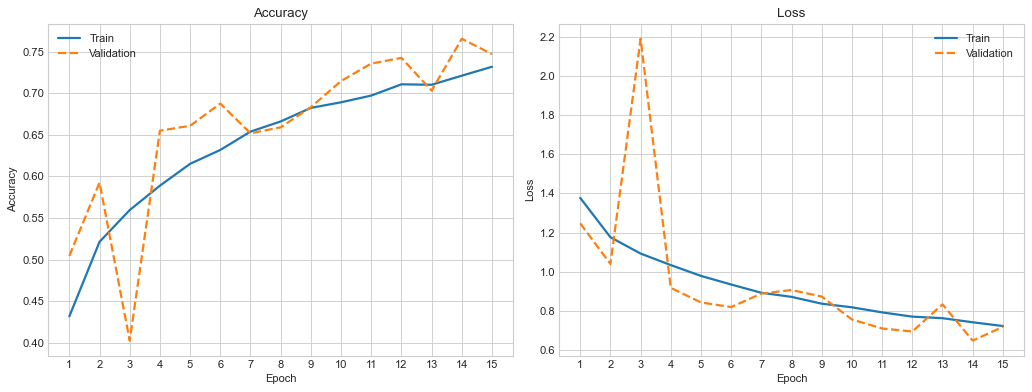

In [7]:
# Gets metrics from model history
acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(acc) + 1)

# Set global theme of matplotlib to seaborn theme
plt.style.use("seaborn-v0_8-whitegrid")

fig, ax = plt.subplots(1, 2, figsize=(13, 5), dpi=80)

# Accuracy
ax[0].plot(epochs, acc, label='Train', linewidth=2)
ax[0].plot(epochs, val_acc, '--', label='Validation', linewidth=2)
ax[0].set_title('Accuracy')
ax[0].set_xlabel('Epoch')
ax[0].set_ylabel('Accuracy')
ax[0].set_xticks(epochs)
ax[0].legend()

# Loss
ax[1].plot(epochs, loss, label='Train', linewidth=2)
ax[1].plot(epochs, val_loss, '--', label='Validation', linewidth=2)
ax[1].set_title('Loss')
ax[1].set_xlabel('Epoch')
ax[1].set_ylabel('Loss')
ax[1].set_xticks(epochs)
ax[1].legend()

plt.tight_layout()
plt.show()

**Confusion Matrix**: Illustrates correct vs incorrect predictions for each class.

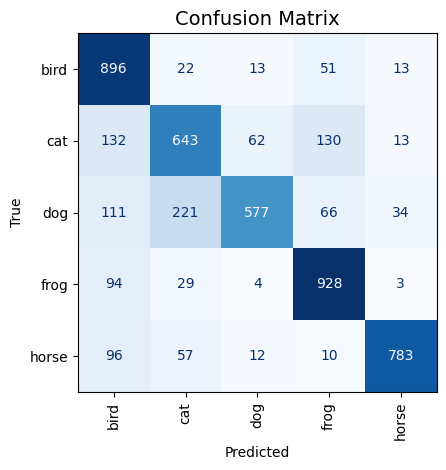

In [8]:
# Collect predictions for entire validation set
y_true = []
y_pred = []

for x, y in val_data:
    y_true.extend(tf.argmax(y, axis=1).numpy())
    y_pred.extend(tf.argmax(model(x, training=False), axis=1).numpy())

# Confusion Matrix
cm = confusion_matrix(y_true, y_pred)

# Set theme to default. Added to prevent unexpected visualization set earlier
plt.style.use('default')

# Plot and Display 
disp = ConfusionMatrixDisplay(cm, display_labels=class_names)
disp.plot(cmap='Blues', xticks_rotation='vertical', colorbar=False)

plt.title("Confusion Matrix", fontsize=14)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.tight_layout()
plt.show()


## Test and Evaluate Trained Model
Using Intel Image Classification test dataset, we can evaluate our trained model using unbiased data to check how well it performs

Found 5000 files belonging to 5 classes.
79/79 ━━━━━━━━━━━━━━━━━━━━ 12s 145ms/step - accuracy: 0.7520 - loss: 0.6868
79/79 ━━━━━━━━━━━━━━━━━━━━ 5s 56ms/step


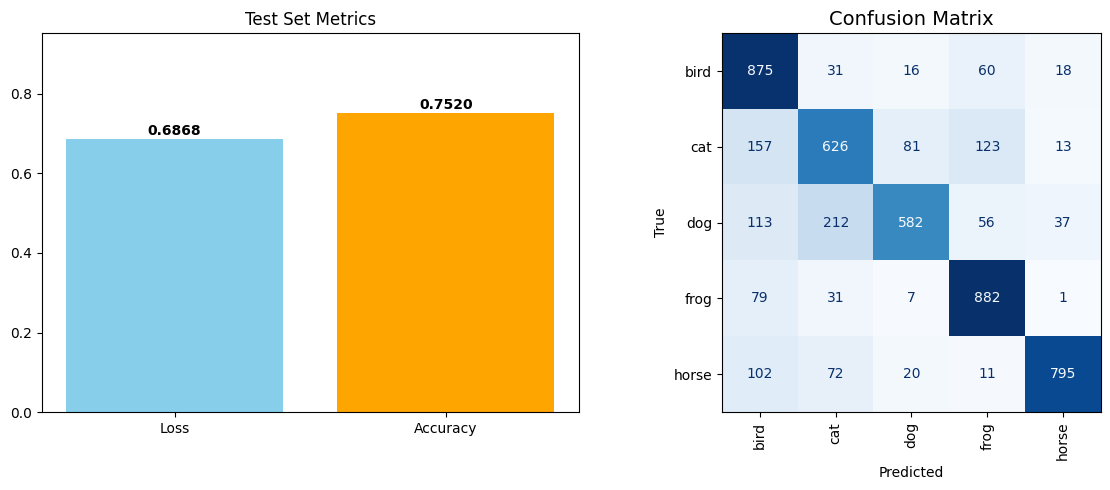

In [9]:
# Evaluate on test set after training
# We will be using already provided test directory from Intel image dataset

# Assign corresponding directories to variables.
test_dir = os.path.join(target_dir, "cifar10/test")

# Get test data
test_data = image_dataset_from_directory(
    test_dir,
    image_size=(32,32),
    batch_size=64,
    label_mode='categorical',
    shuffle=False
)

# Evaluate model
test_loss, test_acc = model.evaluate(test_data)

# get Metrics
metrics = [test_loss, test_acc]
labels = ['Loss', 'Accuracy']

# Compute confusion matrix
y_test_true = np.concatenate([np.argmax(y.numpy(), axis=1) for x, y in test_data])
y_test_pred = np.argmax(model.predict(test_data), axis=1)
test_cm = confusion_matrix(y_test_true, y_test_pred)

fig, axes = plt.subplots(1, 2, figsize=(12, 5))

# Bar Chart
axes[0].bar(labels, metrics, color=['skyblue', 'orange'])
axes[0].set_title("Test Set Metrics")
for i, v in enumerate(metrics):
    axes[0].text(i, v + 0.01, f"{v:.4f}", ha='center', fontweight='bold')
axes[0].set_ylim(0, max(metrics)+0.2)

# Confusion Matrix
test_disp = ConfusionMatrixDisplay(test_cm, display_labels=test_data.class_names)
test_disp.plot(cmap='Blues', xticks_rotation='vertical', colorbar=False, ax=axes[1])
axes[1].set_title("Confusion Matrix", fontsize=14)
axes[1].set_xlabel("Predicted")
axes[1].set_ylabel("True")

plt.tight_layout()
plt.show()

## Interactive Testing

Intel Image Classification Dataset used in this coursework offers other directory called seg_pred without labels. The images can be used to test already trained model to see if our model working as expected. User required image to upload and model expected to predict what image represent using trained labels.

In [10]:
# Create Upload widget of Jupyter Notebook
upload = widgets.FileUpload(accept='image/*', multiple=False)
upload

FileUpload(value=(), accept='image/*', description='Upload')

In [11]:
# Create an output widget to capture cell output
out = widgets.Output()

# Define what happens when the button is clicked
def run_cell(b):
    with out:
        clear_output()  # clear previous output


        if upload.value:
            # Handle both tuple and dict formats
            file_obj = upload.value[0] if isinstance(upload.value, tuple) else list(upload.value.values())[0]
        
            # Read file bytes
            img = Image.open(io.BytesIO(file_obj['content'])).convert('RGB')
        
            # Resize for model
            img_resized = img.resize((128, 128))
            img_array = np.array(img_resized) / 255.0
            img_array = np.expand_dims(img_array, axis=0)
        
            # Predict
            preds = model.predict(img_array)
            pred_class = train_data.class_names[np.argmax(preds)]
        
            # Display
            plt.figure(figsize=(4,4))
            plt.imshow(img)
            plt.axis('off')
            plt.show()
            print("Predicted class:", pred_class)

# Create the button
button = widgets.Button(description="Run Test Evaluation")
button.on_click(run_cell)

# Display the button and output area
display(button, out)


Button(description='Run Test Evaluation', style=ButtonStyle())

Output()